<a href="https://colab.research.google.com/github/guang-zh/ai4genomics_TCGA_Benchmark/blob/master/tcga_guang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Auto Encoder (AE), Variational Auto Encoder (VAE), 
## conditional Variational Auto Encoder (cVAE)

Different Generative Models:
*   CNN: spatial data & many filters
*   GAN: generator & discriminator
*   AE: Encoder & Decoder, features learned through compressions
*   VAE: trade-off of latent loss & reconstruction loss; hidden neurons fit into a specific distribution
*   cVAE: latent variables, data, both conditioned to some random variables

*   VAE vs AE: VAE added the distribution fitting & latent vector
*   VAE vs cVAE: cVAE added the conditions using one-hot vectors

# Step 1 - Download the datasets

In [0]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PROJ = "My Drive/AI4genomics/TCGA_Benchmark-master" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

In [0]:
from importlib.machinery import SourceFileLoader
TCGA = SourceFileLoader('tcga', join(PROJECT_PATH, 'meta_dataloader/TCGA.py')).load_module()

In [0]:
import sys
import pdb

# import meta_dataloader.TCGA

#import models.mlp, models.gcn
import numpy as np
# import data.gene_graphs
import collections
import sklearn.metrics
import sklearn.model_selection
import random
from collections import OrderedDict
import pandas as pd
from torch.optim import Optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
%load_ext autoreload
%autoreload 2

Here we only do this to know the size of the samples

In [0]:
import h5py
f1 = h5py.File('drive/My Drive/AI4genomics/TCGA_Benchmark-master/meta_dataloader/data/TCGA_HiSeqV2.hdf5', 'r')
dset = f1['dataset']
print(dset.shape)

(10459, 20530)


In [0]:
print(sys.version)

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [0]:
tasks = TCGA.TCGAMeta(min_samples_per_class=10)
#task = tasks[113]

/content/drive/My Drive/AI4genomics/TCGA_Benchmark-master/meta_dataloader/TCGA.py:39: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(hdf_file)


In [0]:
len(tasks)

174

In [0]:
# for taskid in tasks.task_ids:
#     task_name = taskid
    task = TCGA.TCGATask(tasks.task_ids[0])
    # print(task)
    print(tasks[0])
    print(task.__dict__.keys())
    print(len(task._samples))
    print(task._samples)
    print(task._samples[0])

dict_keys(['id', 'transform', 'target_transform', 'gene_ids', '_all_sample_ids', '_labels', 'categories', 'num_classes', '_samples', 'input_size'])
45
[[10.123   4.9528  0.     ... 11.3176  3.6325 10.9319]
 [10.1826  5.5601  0.     ... 11.5091  7.4343 10.5548]
 [11.9779  6.0303  0.     ... 12.7958  7.7172 10.2364]
 ...
 [10.2125  7.3929  0.     ... 11.4442  0.9771 10.5199]
 [ 9.7362  4.7061  0.     ... 11.4838  7.9821 11.4966]
 [11.9084  6.284   0.     ... 12.7581  6.8495 10.1681]]
[10.123   4.9528  0.     ... 11.3176  3.6325 10.9319]


# Step 2 - Load and preprocess the dataset 

## 2.1 Single Task (train & test sets)

In [0]:
# create the test-train steps
def load_sets(task, valid=False):
     
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(task._samples, 
                                                                                task._labels, 
                                                                                stratify=task._labels,
                                                                                train_size=0.80,
                                                                                test_size=0.20,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                                 )
    
    train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
    test_set = TensorDataset( Tensor(X_test), Tensor(y_test))
    
    return train_set, test_set 

In [0]:
task = tasks[0]
train_set, test_set = load_sets(task, valid=False)

In [0]:
print(len(train_set))
print(len(test_set))

In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=True)

print(len(train_loader))
print(len(test_loader))

In [0]:
print(vars(train_loader))
print(train_loader.__dict__.keys())

## 2.2 All tasks (test, train sets)

### Define load_all_tasks_sets



In [0]:
import numpy as np

all_X = np.load(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'))
all_Y = np.load(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'))

In [0]:
import os.path
import pdb

def load_all_tasks_sets(tasks):
  # When task ID is provided, each sample should be a vector [gene1, gene2, ...., gene20k, 0, 0, 0, 0, 1, 0, 0]
  # How to compute one hot encoding of the ith task [0, 0, 0, 0, 1, 0, 0]?? vector zero everywhere but in the ith index
  # one_hot = np.zeros(173)
  # one_hot[cpt] = 1

    # Here we load the arrays if they have been saved already
    # if os.path.isfile(join(PROJECT_PATH, 'meta_dataloader/all_X.npy')):
    #   all_X = np.load(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'))
    #   all_Y = np.load(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'))
    # else:
      
    #   all_X = []
    #   all_Y = []

    # cpt = 0
      
    # for taskid in tasks.task_ids:
    #   cpt += 1
    #   print(cpt)
        
    #   task = TCGA.TCGATask(taskid)
        # all_X.append(task._samples)
        # all_Y.append(task._labels)

        

      # all_X = np.concatenate(all_X, axis=0)
      # all_Y = np.concatenate(all_Y, axis=0)

      # np.save(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'), all_X)
      # np.save(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'), all_Y)
        
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_X, 
                                                                                all_Y, 
                                                                                train_size=0.8,
                                                                                test_size=0.2)
    all_train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
    all_test_set = TensorDataset( Tensor(X_test), Tensor(y_test))
    
    return all_train_set, all_test_set

In [0]:
all_train_set, all_test_set = load_all_tasks_sets(tasks)

In [0]:
all_X = np.load(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'))
all_Y = np.load(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'))
print(len(all_X))
print(len(all_Y))

930
930


In [0]:
print(len(all_train_set))
print(len(all_test_set))

744
186


In [0]:
all_train_loader = torch.utils.data.DataLoader(all_train_set, batch_size=32,
                                         shuffle=True)
all_test_loader = torch.utils.data.DataLoader(all_test_set, batch_size=32,
                                         shuffle=True)

print(len(all_train_loader))
print(len(all_test_loader))

24
6


In [0]:
print(tasks[0].__dict__.keys())
print(tasks[0]._samples)
print(tasks[0]._labels)
print(len(tasks[0]._labels))
print(len(tasks[0]._samples))

dict_keys(['id', 'transform', 'target_transform', '_all_sample_ids', 'gene_ids', '_data', '_labels', 'categories', 'num_classes', '_samples', 'input_size'])
[[11.4675  3.4911  0.     ... 12.4365  6.3593 10.1622]
 [11.3709  2.5632  0.4949 ... 11.5841  4.0125 10.5705]
 [11.3932  2.2108  0.     ... 12.1006  2.6879 10.7528]
 ...
 [11.079   5.3147  0.     ... 11.7425  7.1552 10.3814]
 [11.1064  5.8366  0.     ... 11.7407  6.8453 10.8219]
 [10.8232  3.4057  0.     ... 12.5494  6.3637  9.9869]]
(1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,

## 2.3 All tasks (with conditions) - Define load_all_tasks_conditions_sets

In [0]:
import numpy as np

all_X = np.load(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'))
all_Y = np.load(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'))
all_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'))
task_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/task_one_hot.npy')) 

### Define, save, load one_hot array

In [0]:
# import os.path
# import pdb
# import numpy as np

# def load_all_one_hot(tasks):

#   all_one_hot = []
#   cpt = 0
      
#   for taskid in tasks.task_ids:
        
#     one_hot = np.zeros((1,174))
#     one_hot[0, cpt] = 1
#     cpt += 1
#     print(cpt, one_hot)
        
#     task = TCGA.TCGATask(taskid)
#     all_one_hot.append(one_hot)

#   all_one_hot = np.concatenate(all_one_hot, axis=0)

#   np.save(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'), all_one_hot)

#   return all_one_hot 

In [0]:
# all_one_hot = load_all_one_hot(tasks)
# # all_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'))

### Define, save, load task_one_hot

In [0]:
# import os.path
# import pdb
# import numpy as np

# # Load first the saved all_X, all_Y, all_one_hot
# # Return Array of task_one_hot for all the samples

# def load_task_one_hot(tasks):
#   # When task ID is provided, each sample should be a vector [gene1, gene2, ...., gene20k, 0, 0, 0, 0, 1, 0, 0]
#   # How to compute one hot encoding of the ith task [0, 0, 0, 0, 1, 0, 0]?? vector zero everywhere but in the ith index
#   # all_X = np.load(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'))
#   # all_Y = np.load(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'))
#   # all_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'))    
  
#   task_one_hot = []
#   cpt = 0
  
#   for taskid in tasks.task_ids:
#     task = TCGA.TCGATask(taskid)
#     cpt += 1
  
#     for j in range(0, len(task._samples)):
#       task_one_hot.append(all_one_hot[cpt-1])

#   np.save(join(PROJECT_PATH, 'meta_dataloader/task_one_hot.npy'), task_one_hot)

#   return task_one_hot

In [0]:
# task_one_hot = load_task_one_hot(tasks)

In [0]:
# print(len(task_one_hot))
# print(len(all_X))

### Define load_all_tasks_conditions_sets

In [0]:
import os.path
import pdb
import numpy as np

# Load all_X, all_Y, all_one_hot, task_one_hot

def load_all_tasks_conditions_sets(tasks, valid = False, one_hot = False):

  # all_X = np.load(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'))
  # all_Y = np.load(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'))
  # all_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'))    
  # task_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/task_one_hot.npy'))

  all_X_task = []
  
  for i in range(0, len(all_X)):
    X_task = np.append(all_X[i], task_one_hot[i], axis=0)
    all_X_task.append(X_task)

  if ((valid == True) and (one_hot == True)):
      X_train_conditions, X_test_conditions, y_train_conditions, y_test_conditions = sklearn.model_selection.train_test_split(all_X_task, 
                                                                                      all_Y, 
                                                                                      random_state=1,
                                                                                      test_size=0.2)
      X_train_conditions, X_valid_conditions, y_train_conditions, y_valid_conditions = sklearn.model_selection.train_test_split(X_train_conditions, 
                                                                                        y_train_conditions, 
                                                                                        random_state=1,
                                                                                        test_size=0.25) # 0.25 x 0.8 = 0.2 for valid_set

      all_train_conditions_set = TensorDataset( Tensor(X_train_conditions), Tensor(y_train_conditions))
      all_valid_conditions_set = TensorDataset( Tensor(X_valid_conditions), Tensor(y_valid_conditions))
      all_test_conditions_set = TensorDataset( Tensor(X_test_conditions), Tensor(y_test_conditions))
      
      return all_train_conditions_set, all_valid_conditions_set, all_test_conditions_set
    
  elif ((valid == True) and (one_hot == False)): 
      X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_X, 
                                                                              all_Y, 
                                                                              random_state=1,
                                                                              test_size=0.2)
      X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_train, 
                                                                              y_train, 
                                                                              random_state=1,
                                                                              test_size=0.25) # 0.25 x 0.8 = 0.2 for valid_set
      all_train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
      all_valid_set = TensorDataset( Tensor(X_valid), Tensor(y_valid))
      all_test_set = TensorDataset( Tensor(X_test), Tensor(y_test))

      return all_train_set, all_valid_set, all_test_set


  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_X_task, 
                                                                              all_Y, 
                                                                              train_size=0.8,
                                                                              test_size=0.2)
  all_train_conditions_set = TensorDataset( Tensor(X_train), Tensor(y_train))
  all_test_conditions_set = TensorDataset( Tensor(X_test), Tensor(y_test))

  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_X, 
                                                                              all_Y, 
                                                                              train_size=0.8,
                                                                              test_size=0.2)
  all_train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
  all_test_set = TensorDataset( Tensor(X_test), Tensor(y_test))
    
  return all_train_conditions_set, all_test_conditions_set, all_train_set, all_test_set

### Split Train, Valid, Test sets

In [0]:
all_train_conditions_set, all_valid_conditions_set, all_test_conditions_set = load_all_tasks_conditions_sets(tasks, valid=True, one_hot=True)

In [0]:
print(len(all_train_conditions_set))
print(len(all_valid_conditions_set))
print(len(all_test_conditions_set))
print(all_train_conditions_set[0])
print(all_valid_conditions_set[0])
print(all_test_conditions_set[0])

31063
10355
10355
(tensor([10.1866,  0.8395,  0.8395,  ...,  0.0000,  0.0000,  0.0000]), tensor(1.))
(tensor([9.1070, 4.1632, 4.3483,  ..., 0.0000, 0.0000, 0.0000]), tensor(0.))
(tensor([11.4741,  1.2091,  2.0219,  ...,  0.0000,  0.0000,  0.0000]), tensor(2.))


In [0]:
all_train_conditions_loader = torch.utils.data.DataLoader(all_train_conditions_set, batch_size=32,
                                         shuffle=True)
all_valid_conditions_loader = torch.utils.data.DataLoader(all_valid_conditions_set, batch_size=32,
                                         shuffle=True)
all_test_conditions_loader = torch.utils.data.DataLoader(all_test_conditions_set, batch_size=32,
                                         shuffle=True)

print(len(all_train_conditions_loader))
print(len(all_valid_conditions_loader))
print(len(all_test_conditions_loader))

971
324
324


In [0]:
all_train_set, all_valid_set, all_test_set = load_all_tasks_conditions_sets(tasks, valid=True, one_hot=False)

In [0]:
print(len(all_train_set))
print(len(all_valid_set))
print(len(all_test_set))
print(all_train_set[0])
print(all_valid_set[0])
print(all_test_set[0])

In [0]:
all_train_loader = torch.utils.data.DataLoader(all_train_set, batch_size=32,
                                         shuffle=True)
all_valid_loader = torch.utils.data.DataLoader(all_valid_set, batch_size=32,
                                         shuffle=True)
all_test_loader = torch.utils.data.DataLoader(all_test_set, batch_size=32,
                                         shuffle=True)
print(len(all_train_conditions_loader))
print(len(all_valid_conditions_loader))
print(len(all_test_conditions_loader))

# Step 3: Define the model

In [0]:
from torch.nn.utils import spectral_norm
import torch
import torch.nn as nn


class Dummy(torch.nn.Module):
    """
    Helper class that allows you to do nothing. Replaces `lambda x: x`.
    """

    def forward(self, x):
        return x


class LinearBatch(nn.Module):
    """A linear layer with batch normalization."""
    def __init__(self, input_dim, output_dim, bias=True):
        super(LinearBatch, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=bias)
        self.batch_norm = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        out = self.linear(x)
        return self.batch_norm(out)


class LinearSpec(nn.Module):
    """A linear layer with spectral normalization."""
    def __init__(self, input_dim, output_dim, bias=True):
        super(LinearSpec, self).__init__()
        self.linear = spectral_norm(nn.Linear(input_dim, output_dim, bias=bias))

    def forward(self, x):
        return self.linear(x)


class LinearLayers(nn.Module):
    """
    A basic feed forward network with configurable dropout and layer-wise
    normalization.
    """
    def __init__(self, layers, dropout=0, norm='none', modulelist=False,
                 bias=True, activate_final=True):
        super(LinearLayers, self).__init__()

        norm_dict = {
            'batch': LinearBatch, 'spectral': LinearSpec, 'none': nn.Linear}

        assert 0 <= dropout < 1
        assert norm in norm_dict.keys()

        # Set up the linear layers.
        self.linear = norm_dict[norm]
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

        arch = []
        n_layers = len(layers)
        for i in range(n_layers-1):
            arch.append(self.linear(layers[i], layers[i+1], bias=bias))

            # Add activation to all layers, except the final one optionally.
            if activate_final or i+1 < n_layers-1:
                arch.append(self.activation)

                # Only dropout the activated layers.
                if dropout > 0:
                    arch.append(self.dropout)

        # Allows for the linear layer to be a passthrough in the case that
        # the number of layers requested is empty or a single value.
        if len(arch) > 0:
            if modulelist:
                self.model = nn.ModuleList(arch)
            else:
                self.model = nn.Sequential(*arch)
        else:
            self.model = Dummy()

    def embed(self, X):
        return self.model(X)

    def forward(self, X):
        return self.embed(X)


class AutoEncoder(nn.Module):
    """
    A basic feed forward classifier architecture with configurable dropout and
    layer-wise normalization.
    """
    def __init__(self, layers, dropout=0, norm='none'):
        """
        An MLP vanilla antoencoder.
        """
        super(AutoEncoder, self).__init__()

        # assert num_classes >= 1
        self.encoder = LinearLayers(layers=layers, dropout=dropout, norm=norm)
        self.decoder = LinearLayers(layers=layers[::-1], dropout=dropout,
                                    norm=norm, activate_final=False)
        self.criterion = torch.nn.MSELoss(reduction='sum')

    def embed(self, x):
        return self.encoder(x)

    def forward(self, x, fingerprint=0, compound=0, line=0):
        z = self.encoder(x)
        X_prime = self.decoder(z)
        return {'z': z, 'x_prime': X_prime, 'x': x}

    def loss(self, outputs):
        recon_loss = self.criterion(outputs['x_prime'], outputs['x'])
        return {'recon_loss': recon_loss}


class VariationalAutoEncoder(nn.Module):
    """
    A basic feed forward classifier architecture with configurable dropout and
    layer-wise normalization with ~*~ variational inference ~*~.
    """
    def __init__(self, layers, beta=0.5, dropout=0, norm='none'):
        """
        An MLP variational antoencoder.
        """
        super(VariationalAutoEncoder, self).__init__()

        self.encoder = LinearLayers(layers=layers[:-1], dropout=dropout, norm=norm)
        self.mu = LinearLayers(layers=[layers[-2], layers[-1]], activate_final=False)
        self.logvar = LinearLayers(layers=[layers[-2], layers[-1]], activate_final=False)
        self.decoder = LinearLayers(layers=layers[::-1], dropout=dropout,
                                    norm=norm, activate_final=False)
        self.criterion = torch.nn.MSELoss(reduction='sum')
        self.beta = beta

    def embed(self, X):
        h = self.encoder(X)
        mu = self.mu(h)
        logvar = self.logvar(h)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        z = mu + (std * eps)

        return z

    def decode(self, z):
        x_prime = self.decoder(z)

        return x_prime

    def forward(self, x, fingerprint=0, compound=0, line=0):
        mu, logvar = self.embed(x)
        z = self.reparameterize(mu, logvar)
        x_prime = self.decoder(z)
        return {'z': z, 'x_prime': x_prime, 'x': x, 'mu': mu, 'logvar': logvar}

    def loss(self, outputs):
        recon_loss = self.criterion(outputs['x_prime'], outputs['x'])
        kl_div = -0.5 * torch.sum(1 + outputs['logvar'] - outputs['mu'].pow(2) - outputs['logvar'].exp())

        # Apply beta scaling factor
        kl_div *= self.beta

        return {'recon_loss': recon_loss, 'kl_div': kl_div}


## 3.1 Auto Encoder

In [0]:
modelAE = AutoEncoder(layers=[20704, 256, 64], dropout=0, norm='none')

In [0]:
modelAE

AutoEncoder(
  (encoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=20704, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): ReLU()
    )
  )
  (decoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=20704, bias=True)
    )
  )
  (criterion): MSELoss()
)

## 3.2 Variational Auto Encoder (VAE)

In [0]:
modelVAE=VariationalAutoEncoder(layers=[20704, 256, 64], dropout=0, norm='none')

In [0]:
modelVAE

VariationalAutoEncoder(
  (encoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=20704, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (mu): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (logvar): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (decoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=20704, bias=True)
    )
  )
  (criterion): MSELoss()
)

## 3.4 Conditional VAE (CVAE)

In [0]:
modelCVAE=VariationalAutoEncoder(layers=[20704, 256, 64], beta=0.5, dropout=0, norm='none')

In [0]:
modelCVAE

VariationalAutoEncoder(
  (encoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=20704, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (mu): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (logvar): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (decoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=20704, bias=True)
    )
  )
  (criterion): MSELoss()
)

# Step 4 - Define loss function and optimizer

## 4.1 Define Optimizer (lr) for model AE (Autoencoder)

In [0]:
"""
We will use the cross entropy loss and Adam optimizer
"""
import torch.optim as optim

# # Define the cost function
# criterion = nn.CrossEntropyLoss()
# I am not sure whether to keep it or not since I am adding a VAE_loss below !

# Define the optimizer, learning rate 
optimizer_AE = optim.Adam(modelAE.parameters(), lr=0.0001)

## 4.2 Define optimizer (lr) for model VAE

In [0]:
"""
We will use the cross entropy loss and Adam optimizer
"""
import torch.optim as optim

# Define the optimizer, learning rate 
optimizer_VAE = optim.Adam(modelVAE.parameters(), lr=0.0001)



## 4.3 Define optimizer (lr) for model cVAE

In [0]:
"""
We will use the cross entropy loss and Adam optimizer
"""
import torch.optim as optim

# Define the optimizer, learning rate 
optimizer_CVAE = optim.Adam(modelCVAE.parameters(), lr=0.0001)

# Step 5 - Train the network on the training data

## 5.1 Auto Encoder - All Tasks Training

In [0]:
import pdb
from torch.autograd import Variable
import torch.optim as optim

num_epochs = 20
all_losses_AE=[]

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(all_train_conditions_loader, 0):

        # pdb.set_trace()
        # forward propogation
        outputs = modelAE(inputs)
        
        # calculate the loss
        losses = modelAE.loss(outputs)
        loss = losses['recon_loss']
        # pdb.set_trace()
        all_losses_AE.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer_AE.zero_grad()
        loss.backward()
        optimizer_AE.step()

        # print statistics
        cost = loss.item()
        if i % 100 == 0:    # print every 100 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))

In [0]:
# print last losses value for train_AE
print(len(all_losses_AE))
print(all_losses_AE[19419])

19420
365712.94


In [0]:
# Auto Encoder valid_size=0.2 beta=0.5 lr=0.0001
import pdb
from torch.autograd import Variable
import torch.optim as optim

num_epochs = 10
all_losses_valid_AE=[]

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(all_valid_conditions_loader, 0):

        outputs = modelAE(inputs)
        
        # calculate the loss
        losses = modelAE.loss(outputs)
        loss = losses['recon_loss']
        # pdb.set_trace()
        all_losses_valid_AE.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer_AE.zero_grad()
        loss.backward()        
        optimizer_AE.step()

        # print statistics
        cost = loss.item()
        if i % 500 == 0:    # print every 500 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", valid cost = " + str(cost))

Epoch:0, Iteration: 0, valid cost = 549243.0
Epoch:1, Iteration: 0, valid cost = 487819.875
Epoch:2, Iteration: 0, valid cost = 573700.0
Epoch:3, Iteration: 0, valid cost = 507153.96875
Epoch:4, Iteration: 0, valid cost = 494301.0625
Epoch:5, Iteration: 0, valid cost = 471096.375
Epoch:6, Iteration: 0, valid cost = 501047.3125
Epoch:7, Iteration: 0, valid cost = 597913.8125
Epoch:8, Iteration: 0, valid cost = 510628.625
Epoch:9, Iteration: 0, valid cost = 506760.875


In [0]:
print(len(all_losses_valid_AE))
print(all_losses_valid_AE[3239])

3240
290273.2


## 5.2 VAE - All Tasks Training

In [0]:
import pdb
from torch.autograd import Variable
import torch.optim as optim

num_epochs = 20
all_losses_VAE=[]

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(all_train_conditions_loader, 0):

        # pdb.set_trace()
        # forward propogation
        outputs = modelVAE(inputs)
        
        # calculate the loss
        losses = modelVAE.loss(outputs)
        loss = losses['recon_loss'] + losses['kl_div']
        # pdb.set_trace()
        all_losses_VAE.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer_VAE.zero_grad()
        loss.backward()        
        optimizer_VAE.step()

        # print statistics
        cost = loss.item()
        if i % 500 == 0:    # print every 500 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))

Epoch:0, Iteration: 0, training cost = 37846136.0
Epoch:0, Iteration: 500, training cost = 1597798.0
Epoch:1, Iteration: 0, training cost = 1302309.5
Epoch:1, Iteration: 500, training cost = 1085213.75
Epoch:2, Iteration: 0, training cost = 1158631.0
Epoch:2, Iteration: 500, training cost = 936789.0
Epoch:3, Iteration: 0, training cost = 1109918.5
Epoch:3, Iteration: 500, training cost = 970290.25
Epoch:4, Iteration: 0, training cost = 797956.5625
Epoch:4, Iteration: 500, training cost = 791221.25
Epoch:5, Iteration: 0, training cost = 703870.625
Epoch:5, Iteration: 500, training cost = 644824.3125
Epoch:6, Iteration: 0, training cost = 677657.5625
Epoch:6, Iteration: 500, training cost = 661698.8125
Epoch:7, Iteration: 0, training cost = 547506.875
Epoch:7, Iteration: 500, training cost = 607945.0
Epoch:8, Iteration: 0, training cost = 566658.0
Epoch:8, Iteration: 500, training cost = 574310.0
Epoch:9, Iteration: 0, training cost = 520656.9375
Epoch:9, Iteration: 500, training cost = 

In [0]:
print(len(all_losses_VAE))
print(all_losses_VAE[19419])

19420
400368.62


In [0]:
# Variational Auto Encoder valid=0.2 beta=0.5 lr=0.0001
import pdb
from torch.autograd import Variable
import torch.optim as optim

num_epochs = 10
all_losses_valid_VAE=[]

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(all_valid_conditions_loader, 0):

        # pdb.set_trace()
        # forward propogation
        outputs = modelVAE(inputs)
        
        # calculate the loss
        losses = modelVAE.loss(outputs)
        loss = losses['recon_loss'] + losses['kl_div']
        # pdb.set_trace()
        all_losses_valid_VAE.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer_VAE.zero_grad()
        loss.backward()        
        optimizer_VAE.step()

        # print statistics
        cost = loss.item()
        if i % 500 == 0:    # print every 500 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))

Epoch:0, Iteration: 0, training cost = 491790.15625
Epoch:1, Iteration: 0, training cost = 412447.8125
Epoch:2, Iteration: 0, training cost = 506019.0625
Epoch:3, Iteration: 0, training cost = 463687.28125
Epoch:4, Iteration: 0, training cost = 451383.34375
Epoch:5, Iteration: 0, training cost = 439023.125
Epoch:6, Iteration: 0, training cost = 461058.75
Epoch:7, Iteration: 0, training cost = 466685.59375
Epoch:8, Iteration: 0, training cost = 419409.59375
Epoch:9, Iteration: 0, training cost = 474741.75


In [0]:
print(len(all_losses_valid_VAE))
print(all_losses_valid_VAE[3239])

3240
295928.94


## 5.3 CVAE (Conditional VAE) - All Tasks with Tasks as conditions Training

In [0]:
import pdb
from torch.autograd import Variable
import torch.optim as optim

num_epochs = 20
all_losses_CVAE=[]

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(all_train_conditions_loader, 0):

        # forward propogation
        outputs = modelCVAE(inputs)
        
        # calculate the loss
        losses = modelCVAE.loss(outputs)
        loss = losses['recon_loss'] + losses['kl_div']
        # pdb.set_trace()
        all_losses_CVAE.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer_CVAE.zero_grad()
        loss.backward()        
        optimizer_CVAE.step()

        # print statistics
        cost = loss.item()
        if i % 500 == 0:    # print every 500 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))

Epoch:0, Iteration: 0, training cost = 38358352.0
Epoch:0, Iteration: 500, training cost = 1746699.5
Epoch:1, Iteration: 0, training cost = 1683694.875
Epoch:1, Iteration: 500, training cost = 1214235.25
Epoch:2, Iteration: 0, training cost = 1418610.75
Epoch:2, Iteration: 500, training cost = 1453820.5
Epoch:3, Iteration: 0, training cost = 1191091.5
Epoch:3, Iteration: 500, training cost = 935416.375
Epoch:4, Iteration: 0, training cost = 961638.0
Epoch:4, Iteration: 500, training cost = 925712.125
Epoch:5, Iteration: 0, training cost = 705289.125
Epoch:5, Iteration: 500, training cost = 799401.6875
Epoch:6, Iteration: 0, training cost = 692938.875
Epoch:6, Iteration: 500, training cost = 748919.125
Epoch:7, Iteration: 0, training cost = 729275.25
Epoch:7, Iteration: 500, training cost = 797150.4375
Epoch:8, Iteration: 0, training cost = 673819.3125
Epoch:8, Iteration: 500, training cost = 741467.9375
Epoch:9, Iteration: 0, training cost = 611913.0
Epoch:9, Iteration: 500, training c

In [0]:
print(len(all_losses_CVAE))
print(all_losses_CVAE[19419])

19420
357765.75


In [0]:
# Conditional Variational Auto Encoder CVAE valid=0.2 beta=0.5 lr=0.0001
import pdb
from torch.autograd import Variable
import torch.optim as optim

num_epochs = 10
all_losses_valid_CVAE=[]

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(all_valid_conditions_loader, 0):

        # forward propogation
        outputs = modelCVAE(inputs)
        
        # calculate the loss
        losses = modelCVAE.loss(outputs)
        loss = losses['recon_loss'] + losses['kl_div']
        # pdb.set_trace()
        all_losses_valid_CVAE.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer_CVAE.zero_grad()
        loss.backward()        
        optimizer_CVAE.step()

        # print statistics
        cost = loss.item()
        if i % 500 == 0:    # print every 500 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))

Epoch:0, Iteration: 0, training cost = 495667.3125
Epoch:1, Iteration: 0, training cost = 461326.125
Epoch:2, Iteration: 0, training cost = 475374.40625
Epoch:3, Iteration: 0, training cost = 467001.21875
Epoch:4, Iteration: 0, training cost = 490323.09375
Epoch:5, Iteration: 0, training cost = 437880.0
Epoch:6, Iteration: 0, training cost = 497874.28125
Epoch:7, Iteration: 0, training cost = 484703.4375
Epoch:8, Iteration: 0, training cost = 521595.15625
Epoch:9, Iteration: 0, training cost = 477167.1875


In [0]:
print(len(all_losses_valid_CVAE))
print(all_losses_valid_CVAE[3239])

3240
292318.34


### Train & Test loader for training and validating models

Train_loader 0.6 for the split with valid sets

In [0]:
# train_size = 0.6   lr=0.0005  beta=0.5
import pdb
from torch.autograd import Variable
import torch.optim as optim

num_epochs = 20
all_losses_CVAE=[]

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(all_train_conditions_loader, 0):

        # forward propogation
        # Add codes, flatten vector
        # inputs = inputs.view(inputs.shape[0], -1)

        outputs = modelCVAE(inputs)
        
        # calculate the loss
        losses = modelCVAE.loss(outputs)
        loss = losses['recon_loss'] + losses['kl_div']
        # pdb.set_trace()
        all_losses_CVAE.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer_CVAE.zero_grad()
        loss.backward()        
        optimizer_CVAE.step()

        # print statistics
        cost = loss.item()
        if i % 1000 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))

Epoch:0, Iteration: 0, training cost = 4785922560.0
Epoch:1, Iteration: 0, training cost = 4461111808.0
Epoch:2, Iteration: 0, training cost = 6740010496.0
Epoch:3, Iteration: 0, training cost = 3165679872.0
Epoch:4, Iteration: 0, training cost = 3864285696.0
Epoch:5, Iteration: 0, training cost = 4514061312.0
Epoch:6, Iteration: 0, training cost = 4818460160.0
Epoch:7, Iteration: 0, training cost = 2142470784.0
Epoch:8, Iteration: 0, training cost = 4641462784.0
Epoch:9, Iteration: 0, training cost = 3830101504.0
Epoch:10, Iteration: 0, training cost = 4724872192.0
Epoch:11, Iteration: 0, training cost = 8258710016.0
Epoch:12, Iteration: 0, training cost = 6552641024.0
Epoch:13, Iteration: 0, training cost = 3161774080.0
Epoch:14, Iteration: 0, training cost = 4538194944.0
Epoch:15, Iteration: 0, training cost = 4647367680.0
Epoch:16, Iteration: 0, training cost = 4124185088.0
Epoch:17, Iteration: 0, training cost = 2829093632.0
Epoch:18, Iteration: 0, training cost = 3013321472.0
Epo

Loop through the Valid Set (0.2) using the trained model

In [0]:
# valid_size=0.2
import pdb
from torch.autograd import Variable
import torch.optim as optim

num_epochs = 10
all_losses_valid_CVAE=[]

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(all_valid_conditions_loader, 0):

        # forward propogation
        # Add codes, flatten vector
        # inputs = inputs.view(inputs.shape[0], -1)

        outputs = modelCVAE(inputs)
        
        # calculate the loss
        losses = modelCVAE.loss(outputs)
        loss = losses['recon_loss'] + losses['kl_div']
        # pdb.set_trace()
        all_losses_valid_CVAE.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer_CVAE.zero_grad()
        loss.backward()        
        optimizer_CVAE.step()

        # print statistics
        cost = loss.item()
        if i % 1000 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", valid cost = " + str(cost))

Epoch:0, Iteration: 0, valid cost = 52022912.0
Epoch:1, Iteration: 0, valid cost = 43463428.0
Epoch:2, Iteration: 0, valid cost = 36209508.0
Epoch:3, Iteration: 0, valid cost = 30278002.0
Epoch:4, Iteration: 0, valid cost = 24169864.0
Epoch:5, Iteration: 0, valid cost = 19586980.0
Epoch:6, Iteration: 0, valid cost = 15602754.0
Epoch:7, Iteration: 0, valid cost = 13778058.0
Epoch:8, Iteration: 0, valid cost = 10515416.0
Epoch:9, Iteration: 0, valid cost = 7893201.0


# Step 6: Visualize Loss History

## 6.1 Auto Encoder - All Tasks Loss History

19420


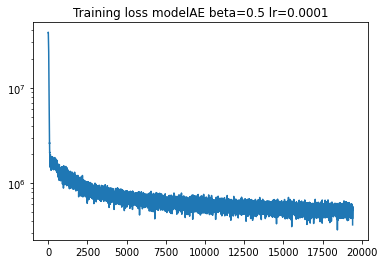

In [0]:
import numpy as np
import matplotlib.pyplot as plt

print(len(all_losses_AE))
plt.plot(all_losses_AE)

plt.yscale('log')
bottom, top = plt.ylim()
plt.ylim(bottom, top)
plt.title("Training loss modelAE beta=0.5 lr=0.0001")
plt.show()

# iterations vs. cost

3240


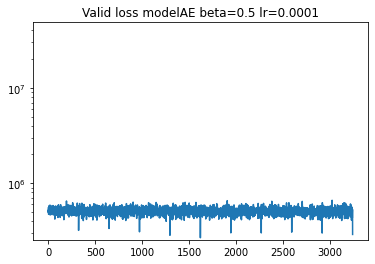

In [0]:
import numpy as np
import matplotlib.pyplot as plt

print(len(all_losses_valid_AE))
plt.plot(all_losses_valid_AE)
plt.yscale('log')
plt.ylim(bottom, top)
plt.title("Valid loss modelAE beta=0.5 lr=0.0001")
plt.show()

# iterations vs. cost

## 6.2 Variational Auto Encoder All Tasks Loss History



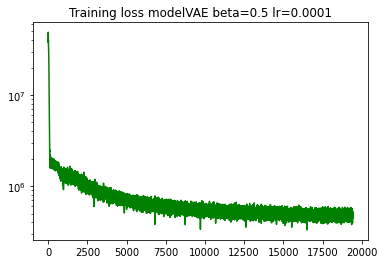

In [0]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(all_losses_VAE, color='green')
plt.yscale('log')
bottom, top = plt.ylim()
plt.ylim(bottom, top)
plt.title("Training loss modelVAE beta=0.5 lr=0.0001")
plt.show()

# iterations vs. cost

3240


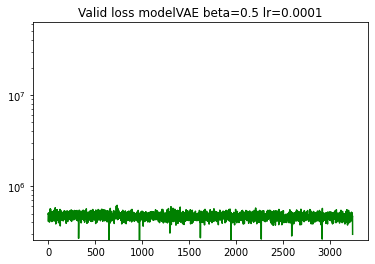

In [0]:
import numpy as np
import matplotlib.pyplot as plt

print(len(all_losses_valid_VAE))
plt.plot(all_losses_valid_VAE, color='green')
plt.yscale('log')
plt.ylim(bottom, top)
plt.title("Valid loss modelVAE beta=0.5 lr=0.0001")
plt.show()

# iterations vs. cost

## 6.3 Conditional Variational Auto Encoder - All Tasks Loss History

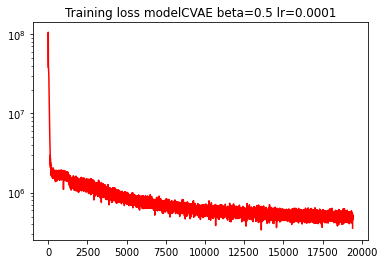

In [0]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(all_losses_CVAE, color='red')
plt.yscale('log')
bottom, top = plt.ylim()
plt.ylim(bottom, top)
plt.title("Training loss modelCVAE beta=0.5 lr=0.0001")
plt.show()

# iterations vs. cost

3240


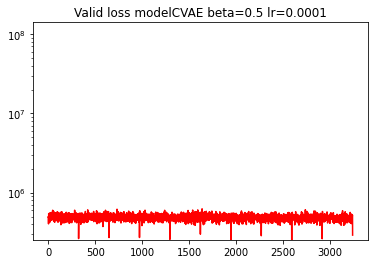

In [0]:
import numpy as np
import matplotlib.pyplot as plt

print(len(all_losses_valid_CVAE))
plt.plot(all_losses_valid_CVAE, color='red')
plt.yscale('log')
plt.ylim(bottom, top)
plt.title("Valid loss modelCVAE beta=0.5 lr=0.0001")
plt.show()

# iterations vs. cost

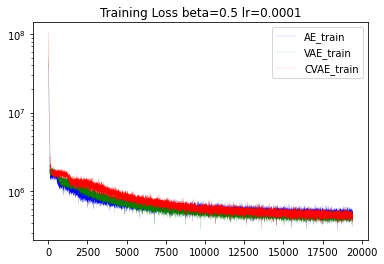

In [0]:
plt.plot(all_losses_AE, label='AE_train', color='blue', linewidth=0.1)
plt.plot(all_losses_VAE, label='VAE_train', color='green', linewidth=0.1)
plt.plot(all_losses_CVAE, label='CVAE_train', color='red', linewidth=0.1)

plt.legend(loc='upper right')
plt.yscale('log')
# bottom, top = plt.ylim()
# plt.ylim(bottom, top)
plt.title("Training Loss beta=0.5 lr=0.0001")
plt.show()

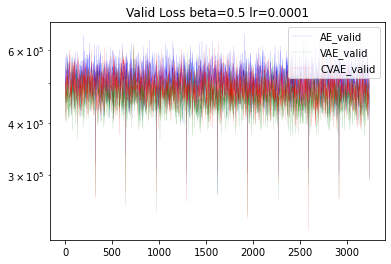

In [0]:
plt.plot(all_losses_valid_AE, label='AE_valid', color='blue', linewidth=0.1)
plt.plot(all_losses_valid_VAE, label='VAE_valid', color='green', linewidth=0.1)
plt.plot(all_losses_valid_CVAE, label='CVAE_valid', color='red', linewidth=0.1)

plt.legend(loc='upper right')
plt.yscale('log')
# bottom, top = plt.ylim()
# plt.ylim(bottom, top)
plt.title("Valid Loss beta=0.5 lr=0.0001")
plt.show()

# Step 7 Saving/Loading Losses/Models

In [0]:
# Save Models
import numpy as np

np.save(join(PROJECT_PATH, 'ai4genomics_models/modelAE_beta5_lr0001.pth'), modelAE)
np.save(join(PROJECT_PATH, 'ai4genomics_models/modelVAE_beta5_lr0001.pth'), modelVAE)
np.save(join(PROJECT_PATH, 'ai4genomics_models/modelCVAE_beta5_lr0001.pth'), modelCVAE)

In [0]:
# Save losses
import os.path
import numpy as np
np.save(join(PROJECT_PATH, 'ai4genomics_models/all_losses_AE_beta5_lr0001.npy'), all_losses_AE)
np.save(join(PROJECT_PATH, 'ai4genomics_models/all_losses_VAE_beta5_lr0001.npy'), all_losses_VAE)
np.save(join(PROJECT_PATH, 'ai4genomics_models/all_losses_CVAE_beta5_lr0001.npy'), all_losses_CVAE)

np.save(join(PROJECT_PATH, 'ai4genomics_models/all_losses_valid_AE_beta5_lr0001.npy'), all_losses_valid_AE)
np.save(join(PROJECT_PATH, 'ai4genomics_models/all_losses_valid_VAE_beta5_lr0001.npy'), all_losses_valid_VAE)
np.save(join(PROJECT_PATH, 'ai4genomics_models/all_losses_valid_CVAE_beta5_lr0001.npy'), all_losses_valid_CVAE)

### Visualize Reconstructions

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

### Saliency Map

In [0]:
idx = 5 # class whose gradient will be computed
def plot_saliency(idx):
    # Forward pass
  data = next(iter(test_loader))
  images, labels = data
  images.requires_grad = True # the gradient with respect to the input will be computed
  outputs = model(images)

  # Backward pass
  loss = outputs[:, idx: idx+1].sum()
  loss.backward(retain_graph=True)
  heatmaps = images.grad.detach().numpy() # The heatmap is the gradient with respect to the input

  # Plot
  fig, axs = plt.subplots(4, 4, figsize=(10, 10))
  fig.suptitle("Saliency maps with respect to class " + str(idx) + ", green corresponds to positive gradient and red to negative")
  for i in range(4):
    for j in range(2):
      axs[i, 2*j].imshow(images[2*i + j].detach())
      axs[i, 2*j].axis('off')
      axs[i, 2*j+1].imshow(heatmaps[2*i + j], cmap="PiYG", vmin=-1, vmax=1)
      axs[i, 2*j+1].axis('off')
  plt.show()
  plot_saliency(idx=1)

### Deep Dream

In [0]:
idx = 3 # class whose gradient will be computed
lr = 0.01 # Learning rate for deep dream
n_iter = 60 # Number of iterations for Deep Dream

In [0]:
# Forward pass
data = next(iter(test_loader))
images, labels = data
pdb.set_trace()
images.requires_grad = True # the gradient with respect to the input will be computed
outputs = model(images)

--Return--
> <ipython-input-92-92005545ce81>(3)<module>()->None
-> pdb.set_trace()
(Pdb) type(images)
<class 'torch.Tensor'>
(Pdb) type(labels)
<class 'torch.Tensor'>
(Pdb) data
[tensor([[ 9.8408,  5.1448,  0.0000,  ..., 12.3571,  6.2719, 10.3849],
        [ 9.6264,  9.1362,  1.1231,  ..., 11.1659,  6.0970, 10.3540],
        [10.2154,  3.9748,  0.7809,  ..., 11.5536,  4.7080, 10.0860],
        ...,
        [ 9.2927,  9.1047,  0.0000,  ..., 10.8198, 10.1195, 10.1235],
        [ 9.2387,  9.3958,  0.0000,  ..., 10.9431,  6.8868, 10.0469],
        [ 9.2712,  9.6177,  0.0000,  ..., 11.1857,  7.0968, 10.5781]]), tensor([2., 0., 2., 0., 0., 2., 2., 0., 0., 0.])]


In [0]:
# The Deep Dream procedure:
img = images

for _ in range(n_iter):
    model.zero_grad()
    outputs = model(img)
    loss = outputs[:, idx: idx+1].sum() # maximize the class idx
    loss.backward(retain_graph=True)
    img = img + lr * img.grad # The gradient is added to the image
    img.data = torch.clamp(img.data, min=0)

    # Trick to forget the computation graph
    img = img.detach().numpy()
    img = torch.Tensor(img)
    img.requires_grad = True

RuntimeError: ignored

In [0]:
# Visualize Before/After:
# The dreamed image is on the right of the corresponding original image

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("Deep Dreaming numbers " + str(idx))
for i in range(4):
  for j in range(2):
    axs[i, 2*j].imshow(images[2*i + j].detach())
    axs[i, 2*j].axis('off')
    axs[i, 2*j+1].imshow(img[2*i + j].detach())
    axs[i, 2*j+1].axis('off')
plt.show()